In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde
import matplotlib
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import pickle
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='cm')

# Helper Functions

In [17]:
def even_spaced(sample, range=None, n=50, fudge=0.05):
    min = np.min(sample) if range is None else range[0]
    max = np.max(sample) if range is None else range[1]
    dist = max - min
    minimum = min - dist*fudge
    maximum = max + dist*fudge
    return np.linspace(minimum, maximum, n)

In [18]:
def component_plot(samp, axes, cmap, ranges=None, bw=None, thin=1):
    n = samp.shape[1]
    # first plot the diagonal
    for i in range(n):
        arange = ranges[i] if ranges is not None else None
        ax = axes[i,i]
        sample = samp[::thin,i]
        x = even_spaced(sample, arange)
        kde = gaussian_kde(sample.T, bw)
        handle, = ax.plot(x, kde(x), c=matplotlib.cm.get_cmap(cmap)(0.5))
        
    # plot below diagonal
    for i in range(n):
        range_i = ranges[i]
        for j in range(i+1, n):
            range_j = ranges[j]
            ax = axes[j,i]
            sample = samp[::thin, [i,j]]
            kde = gaussian_kde(sample.T, bw)
            
            x0 = even_spaced(sample[:,0], range_i)
            x1 = even_spaced(sample[:,1], range_j)
            
            x, y = np.meshgrid(x0, x1)
            z = kde(np.column_stack([x.ravel(), y.ravel()]).T).reshape(x.shape)
            ax.contour(x, y, z, cmap=cmap)
    
    # blank above diagonal
    for i in range(n):
        for j in range(i+1, n):
            ax = axes[i, j]
            ax.set_axis_off()
    return handle     

In [19]:
def component_plot_truth(truth, axes, color='black'):
    n = truth.shape[0]
    for i in range(n):
        ax = axes[i,i]
        ax.axvline(truth[i], linestyle='--', color=color)
        
    for i in range(n):
        for j in range(i+1, n):
            ax = axes[j,i]
            ax.scatter(truth[i], truth[j], marker='x', color=color, zorder=1000)
    return mlines.Line2D([], [], color=color, marker='x', linestyle='--')

In [20]:
def component_plot_axes_off(axes):
    for i in range(1, len(axes)):
        for j in range(0, len(axes)):
            ax = axes[j,i]
            ax.yaxis.set_major_locator(plt.NullLocator())

    for i in range(0, len(axes)):
        for j in range(0, len(axes)-1):
            ax = axes[j,i]
            ax.xaxis.set_major_locator(plt.NullLocator())

In [21]:
def component_plot_set_font_sizes(axes, fontsize):
    for a in axes.ravel():
        for tick in a.xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
        for tick in a.yaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize)

In [22]:
# important helpers!
def plot_circle(x, y, values, cmap=None):
    plt.tricontourf(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

# Temporal Recovery: Principal Components

In [23]:
base_loc = 'results/temporal_recovery_'
n_pts = 12
id_ref = 'n=12_collocation_be7e7a91'
id_coll = 'n=12_collocation_be7e7a91'
id_pmm = 'n=12_6904a854'
#id_coll = 'n=5_collocation_cde5b514'
#id_pmm = 'n=5_aab75251'
n_pcs = 5
thin=1

## Generate the PCs

In [24]:
with open(os.path.join(base_loc + id_ref, 'results.pkl'), 'rb') as f:
    ref_samples = pickle.load(f)[-1]
with open(os.path.join(base_loc + id_coll, 'results.pkl'), 'rb') as f:
    coll_samples = pickle.load(f)[-1]
with open(os.path.join(base_loc + id_pmm, 'results.pkl'), 'rb') as f:
    pmm_samples = pickle.load(f)[-1]

In [25]:
ref_cov = np.cov(ref_samples.T)

In [26]:
gray_cmap = mcolors.LinearSegmentedColormap.from_list('grays_trunc', [(0.7, 0.7, 0.7), (0.1, 0.1, 0.1)])

In [27]:
evals, evecs = np.linalg.eig(ref_cov)
evecs = evecs[:, 0:n_pcs]

In [28]:
truth = np.dot(np.mean(ref_samples, axis=0), evecs) # get the projections onto the eigenvectors
truth_projection = np.dot(ref_samples, evecs)
pmm_projection = np.dot(pmm_samples, evecs)
coll_projection = np.dot(coll_samples, evecs)

In [29]:
pmm_min = np.min(pmm_projection, axis=0)
pmm_max = np.max(pmm_projection, axis=0)
coll_min = np.min(coll_projection, axis=0)
coll_max = np.max(coll_projection, axis=0)
truth_min = np.min(truth_projection, axis=0)
truth_max = np.max(truth_projection, axis=0)
overall_min = np.minimum(pmm_min, coll_min, truth_min)
overall_max = np.minimum(pmm_max, coll_max, truth_max)
ranges = np.c_[overall_min, overall_max]

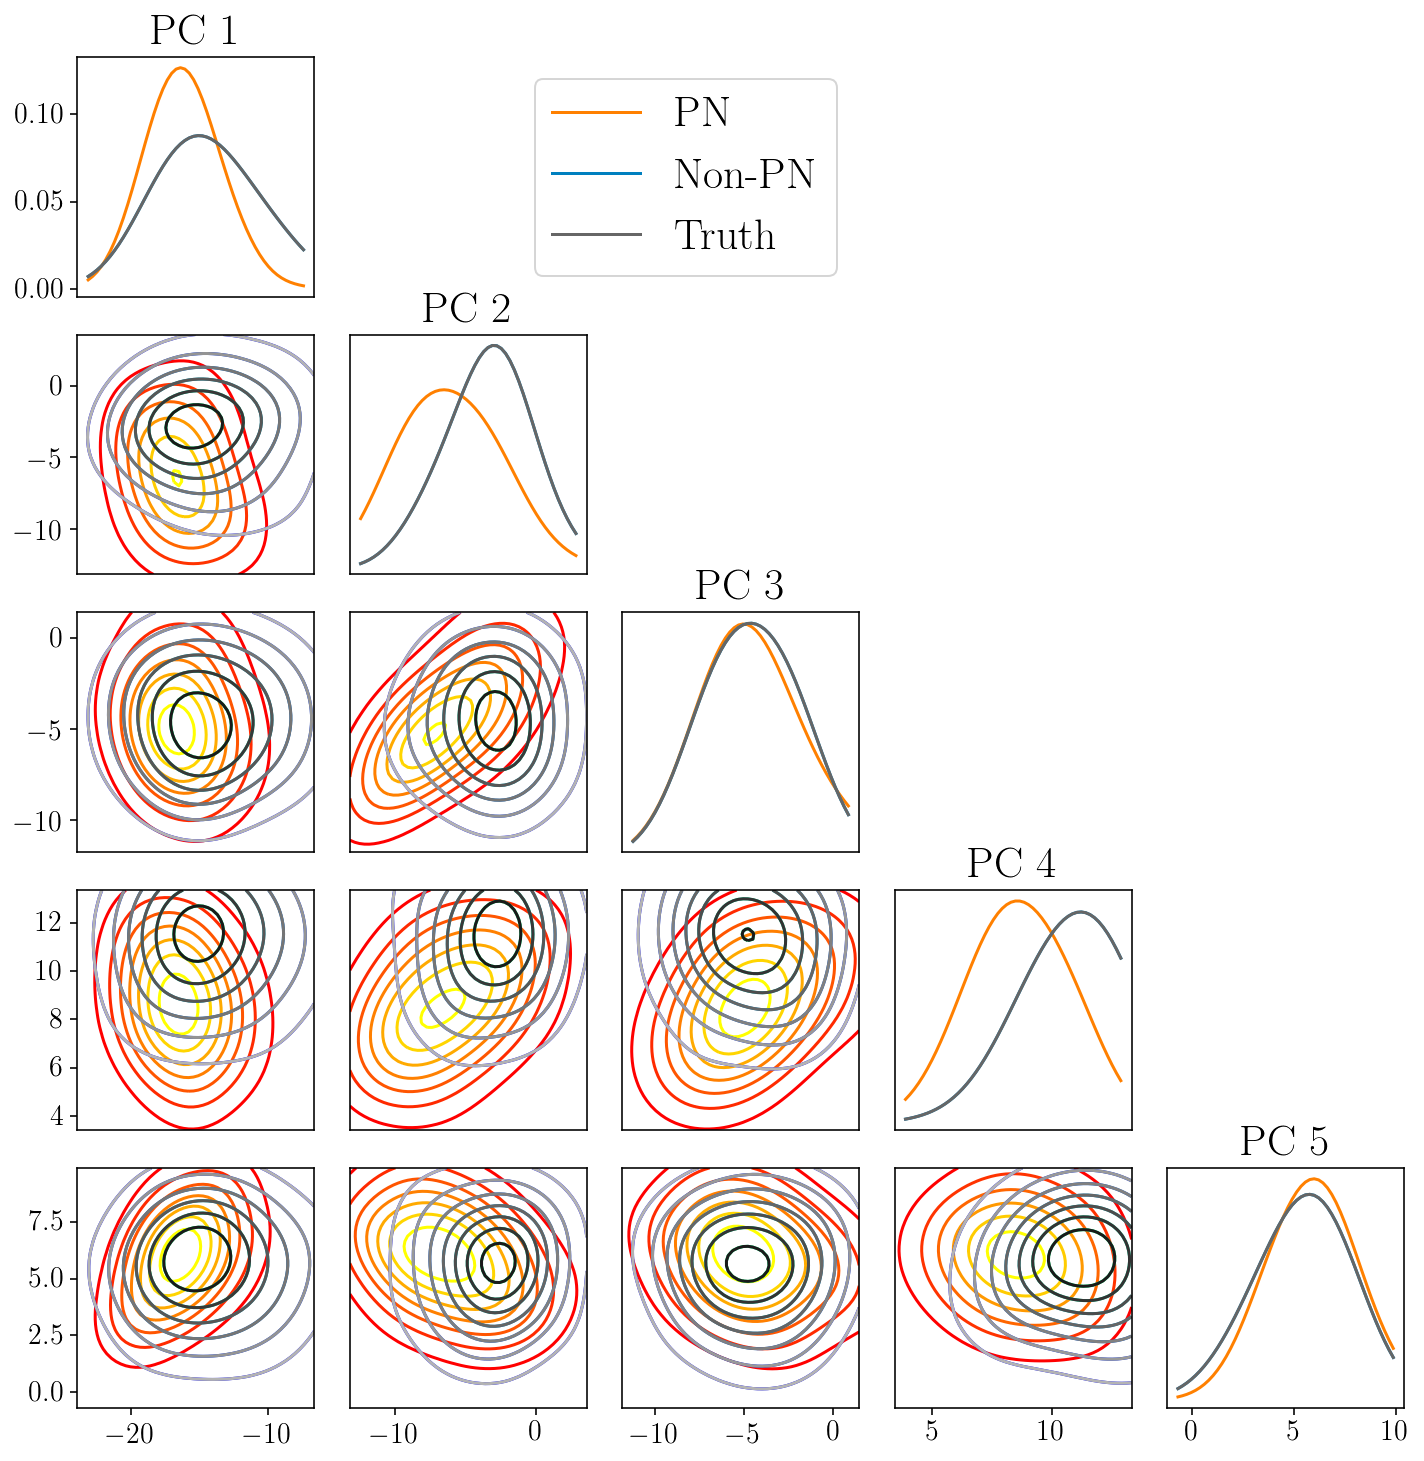

In [30]:
bw = 0.8
fig, axes = plt.subplots(evecs.shape[1], evecs.shape[1], False, False, figsize=(10,10))
h_pmm = component_plot(pmm_projection, axes, cmap='autumn', ranges=ranges, bw=bw, thin=thin)
h_coll = component_plot(coll_projection, axes, cmap='winter', ranges=ranges, bw=bw, thin=thin)
#h_truth = component_plot_truth(truth, axes)
h_truth = component_plot(truth_projection, axes, cmap=gray_cmap, ranges=ranges, bw=bw, thin=thin)
component_plot_axes_off(axes)
component_plot_set_font_sizes(axes, 14)
plt.tight_layout()
axes[0, 2].legend([h_pmm, h_coll, h_truth], ['PN', 'Non-PN', 'Truth'], fontsize=22)
#axes[0, 1].legend([h_pmm, h_truth], ['PN', 'Truth'], fontsize=22)
for i in range(len(axes)):
    axes[i,i].set_title('PC {}'.format(i+1), fontsize=22)
    
plt.savefig('figures/terminal_components_n={}.pdf'.format(n_pts), bbox_inches='tight', transparent=True)